In [ ]:
!pip install transformers==4.51.3

In [ ]:
!pip install datasets

GPT-2

In [ ]:
import io
import os
import gc
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Tokenizer,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification,
                          EarlyStoppingCallback)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

# Set seed for reproducibility
set_seed(47)

epochs = 5
batch_size = 8  # Reduced batch size to prevent memory crashes
accumulation_steps = 4  # Gradient accumulation
max_length = 512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_or_path = 'gpt2'

# Label mapping
labels_ids = {"pants-fire": 0, "false": 0, "barely-true": 0, "half-true": 1, "mostly-true": 1, "true": 1}
n_labels = len(set(labels_ids.values()))

# Initialize lists to store metrics for plotting
train_losses = []
val_losses = []
train_aucs = []
val_aucs = []
best_auc = 0.0
best_epoch = 0

# Load data
train_path = "train_no_empty_evidence.csv"
test_path = "test_no_empty_evidence.csv"
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Dataset class
class FactCheckingDataset(Dataset):
    def __init__(self, data, tokenizer, labels_encoder, max_length):
        self.tokenizer = tokenizer
        self.labels_encoder = labels_encoder
        data.dropna(subset=["statement", "label", "evidence"], inplace=True)
        self.labels = [self.labels_encoder[label] for label in data['label']]
        self.max_length = max_length
        self.texts = [f"{statement} {evidence}" for statement, evidence in zip(data['statement'], data['evidence'])]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        inputs = self.tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        inputs['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return inputs

# Initialize tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token

# Create datasets
train_dataset = FactCheckingDataset(train_data, tokenizer, labels_ids, max_length)
test_dataset = FactCheckingDataset(test_data, tokenizer, labels_ids, max_length)

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Load model
model = GPT2ForSequenceClassification.from_pretrained(model_name_or_path, num_labels=n_labels)
model.config.pad_token_id = model.config.eos_token_id
model.to(device)

# Freeze first 6 layers of GPT-2
for param in model.transformer.h[:6].parameters():
    param.requires_grad = False

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, eps=1e-8)
total_steps = len(train_dataloader) * epochs // accumulation_steps
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Class weights
class_weights = torch.tensor([1.2, 1.0]).to(device)
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)

def compute_metrics(true_labels, predictions, probs):
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

    probs = np.array(probs)  # Convert list to NumPy array
    auc = roc_auc_score(true_labels, probs[:, 1]) if len(set(true_labels)) > 1 else 0.0

    return accuracy, precision, recall, f1, auc

def plot_confusion_matrix(true_labels, predictions, classes):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.close()

def plot_roc_curve(true_labels, probs):
    fpr, tpr, _ = roc_curve(true_labels, probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.close()

def plot_metrics(train_losses, val_losses, train_aucs, val_aucs):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # AUC plot
    plt.subplot(1, 2, 2)
    plt.plot(train_aucs, label='Training AUC')
    plt.plot(val_aucs, label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('Training and Validation AUC')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.close()

# Training function with metrics
def train(dataloader):
    model.train()
    total_loss = 0
    true_labels, predictions, probs = [], [], []
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss, logits = outputs.loss, outputs.logits
        loss = loss / accumulation_steps
        loss.backward()

        if (step + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item()
        true_labels.extend(batch['labels'].cpu().numpy())
        predictions.extend(logits.argmax(dim=-1).cpu().numpy())
        probs.extend(torch.nn.functional.softmax(logits, dim=-1).cpu().detach().numpy())

    accuracy, precision, recall, f1, auc_score = compute_metrics(true_labels, predictions, probs)
    return accuracy, precision, recall, f1, auc_score, total_loss / len(dataloader), true_labels, predictions, probs

def validate(dataloader):
    model.eval()
    total_loss = 0
    true_labels, predictions, probs = [], [], []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss, logits = outputs.loss, outputs.logits
            total_loss += loss.item()
            true_labels.extend(batch['labels'].cpu().numpy())
            predictions.extend(logits.argmax(dim=-1).cpu().numpy())
            probs.extend(torch.nn.functional.softmax(logits, dim=-1).cpu().detach().numpy())

    accuracy, precision, recall, f1, auc_score = compute_metrics(true_labels, predictions, probs)
    return accuracy, precision, recall, f1, auc_score, total_loss / len(dataloader), true_labels, predictions, probs

def train_and_evaluate(train_path, test_path):
    global best_auc, best_epoch

    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)

    train_dataset = FactCheckingDataset(train_data, tokenizer, labels_ids, max_length)
    test_dataset = FactCheckingDataset(test_data, tokenizer, labels_ids, max_length)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_acc, train_prec, train_rec, train_f1, train_auc, train_loss, _, _, _ = train(train_dataloader)
        train_losses.append(train_loss)
        train_aucs.append(train_auc)
        print(f"Training Loss: {train_loss}, Accuracy: {train_acc}, Precision: {train_prec}, Recall: {train_rec}, F1: {train_f1}, AUC: {train_auc}")

        val_acc, val_prec, val_rec, val_f1, val_auc, val_loss, val_true, val_pred, val_probs = validate(test_dataloader)
        val_losses.append(val_loss)
        val_aucs.append(val_auc)
        print(f"Validation Loss: {val_loss}, Accuracy: {val_acc}, Precision: {val_prec}, Recall: {val_rec}, F1: {val_f1}, AUC: {val_auc}")

        # Save best model based on validation AUC
        if val_auc > best_auc:
            best_auc = val_auc
            best_epoch = epoch
            model.save_pretrained("./model_output")
            tokenizer.save_pretrained("./model_output")

            # Save plots for best epoch
            plot_confusion_matrix(val_true, val_pred, classes=['False', 'True'])
            plot_roc_curve(val_true, np.array(val_probs))

    # Plot training metrics
    plot_metrics(train_losses, val_losses, train_aucs, val_aucs)

    print(f"Best validation AUC: {best_auc:.4f} at epoch {best_epoch + 1}")

if __name__ == "__main__":
    train_and_evaluate("train_no_empty_evidence.csv", "test_no_empty_evidence.csv")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


  0%|          | 0/945 [00:00<?, ?it/s]

Training Loss: 0.17300830528376596, Accuracy: 0.5864761148603943, Precision: 0.6036834924965894, Recall: 0.8154803040774016, F1: 0.6937775600195982, AUC: 0.5856679299310863


  0%|          | 0/158 [00:00<?, ?it/s]

Validation Loss: 0.6155761757606193, Accuracy: 0.6265822784810127, Precision: 0.6161137440758294, Recall: 0.9065550906555091, F1: 0.7336343115124153, AUC: 0.7250528430720119
Epoch 2/5


  0%|          | 0/945 [00:00<?, ?it/s]

Training Loss: 0.14826218425912202, Accuracy: 0.660844250363901, Precision: 0.6758306962025317, Recall: 0.7871458189357291, F1: 0.7272533787378951, AUC: 0.7261119033374935


  0%|          | 0/158 [00:00<?, ?it/s]

Validation Loss: 0.5821816129020497, Accuracy: 0.680379746835443, Precision: 0.7035110533159948, Recall: 0.7545327754532776, F1: 0.7281292059219381, AUC: 0.7409070395386016
Epoch 3/5


  0%|          | 0/945 [00:00<?, ?it/s]

Training Loss: 0.13950893307331377, Accuracy: 0.6994839221913458, Precision: 0.7165271966527197, Recall: 0.7889887122782769, F1: 0.7510141431860542, AUC: 0.770956966492119


  0%|          | 0/158 [00:00<?, ?it/s]

Validation Loss: 0.5787015158352973, Accuracy: 0.6732594936708861, Precision: 0.6715575620767494, Recall: 0.8298465829846583, F1: 0.74235807860262, AUC: 0.7525516383264619
Epoch 4/5


  0%|          | 0/945 [00:00<?, ?it/s]

Training Loss: 0.1314044463157496, Accuracy: 0.7288606589916634, Precision: 0.7463456577815993, Recall: 0.7998157106657452, F1: 0.7721561214277771, AUC: 0.8041374989828558


  0%|          | 0/158 [00:00<?, ?it/s]

Validation Loss: 0.5993787503883808, Accuracy: 0.6787974683544303, Precision: 0.6681081081081081, Recall: 0.8619246861924686, F1: 0.7527405602923264, AUC: 0.7495786577732223
Epoch 5/5


  0%|          | 0/945 [00:00<?, ?it/s]

Training Loss: 0.12552037435785804, Accuracy: 0.7485774778351197, Precision: 0.7630954947186894, Recall: 0.8154803040774016, F1: 0.7884187082405345, AUC: 0.8263451588521342


  0%|          | 0/158 [00:00<?, ?it/s]

Validation Loss: 0.6134558294581461, Accuracy: 0.6708860759493671, Precision: 0.6623516720604099, Recall: 0.8563458856345886, F1: 0.7469586374695864, AUC: 0.7490636131147708
Best validation AUC: 0.7526 at epoch 3


In [ ]:
# Save the model and tokenizer after training is complete
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")
print("Model and tokenizer saved to './saved_model' directory.")

Model and tokenizer saved to './saved_model' directory.


BERT-

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.3,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.3,
  "hidden_size": 768,
  "id2label": {
    "0": "barely-true",
    "1": "true"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "barely-true": 0,
    "false": 0,
    "half-true": 1,
    "mostly-true": 1,
    "pants-fire": 0,
    "true": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_em

Map:   0%|          | 0/7557 [00:00<?, ? examples/s]

Map:   0%|          | 0/1264 [00:00<?, ? examples/s]

Using amp half precision backend
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:474: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: evidence, statement, input_text, reason, __index_level_0__, id. If evidence, statement, input_text, reason, __index_level_0__, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples =

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc Roc
0,No log,0.673543,0.583861,0.642306,0.522447,0.423931,0.693311
1,No log,0.584378,0.713608,0.732377,0.685792,0.685480,0.789793


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: evidence, statement, input_text, reason, id. If evidence, statement, input_text, reason, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1264
  Batch size = 16
Configuration saved in ./best_model_auc_0.6933/config.json
Model weights saved in ./best_model_auc_0.6933/pytorch_model.bin
tokenizer config file saved in ./best_model_auc_0.6933/tokenizer_config.json
Special tokens file saved in ./best_model_auc_0.6933/special_tokens_map.json


New best model with AUC-ROC 0.6933 saved to ./best_model_auc_0.6933


Saving model checkpoint to ./model_output/checkpoint-236
Configuration saved in ./model_output/checkpoint-236/config.json
Model weights saved in ./model_output/checkpoint-236/pytorch_model.bin
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:1949: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  ctx_manager = autocast(dtype=self.amp_dtype)
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: evidence, statement, input_text, reason, id. If evidence, statement, input_text, reason, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1264
  Batch size = 16
Configuration saved in ./best_model_auc_0.7898/config.json
Model weights saved in ./best_model_auc_0.7898/pytorch_model.bin
tokenizer config file saved in ./be

New best model with AUC-ROC 0.7898 saved to ./best_model_auc_0.7898


Saving model checkpoint to ./model_output/checkpoint-472
Configuration saved in ./model_output/checkpoint-472/config.json
Model weights saved in ./model_output/checkpoint-472/pytorch_model.bin
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:1949: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  ctx_manager = autocast(dtype=self.amp_dtype)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc Roc
0,No log,0.673543,0.583861,0.642306,0.522447,0.423931,0.693311
1,No log,0.584378,0.713608,0.732377,0.685792,0.685480,0.789793
2,0.626400,0.646892,0.719937,0.730295,0.696356,0.698092,0.790109
3,0.626400,0.661678,0.731013,0.740314,0.709153,0.711845,0.800515
4,0.493100,0.682716,0.737342,0.746835,0.716032,0.719113,0.804391


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: evidence, statement, input_text, reason, id. If evidence, statement, input_text, reason, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1264
  Batch size = 16
Configuration saved in ./best_model_auc_0.7901/config.json
Model weights saved in ./best_model_auc_0.7901/pytorch_model.bin
tokenizer config file saved in ./best_model_auc_0.7901/tokenizer_config.json
Special tokens file saved in ./best_model_auc_0.7901/special_tokens_map.json


New best model with AUC-ROC 0.7901 saved to ./best_model_auc_0.7901


Saving model checkpoint to ./model_output/checkpoint-708
Configuration saved in ./model_output/checkpoint-708/config.json
Model weights saved in ./model_output/checkpoint-708/pytorch_model.bin
Deleting older checkpoint [model_output/checkpoint-236] due to args.save_total_limit
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:1949: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  ctx_manager = autocast(dtype=self.amp_dtype)
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: evidence, statement, input_text, reason, id. If evidence, statement, input_text, reason, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1264
  Batch size = 16
Configuration saved in ./best_model_auc_0.8005/config.json
Model weights s

New best model with AUC-ROC 0.8005 saved to ./best_model_auc_0.8005


Saving model checkpoint to ./model_output/checkpoint-944
Configuration saved in ./model_output/checkpoint-944/config.json
Model weights saved in ./model_output/checkpoint-944/pytorch_model.bin
Deleting older checkpoint [model_output/checkpoint-472] due to args.save_total_limit
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:1949: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  ctx_manager = autocast(dtype=self.amp_dtype)
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: evidence, statement, input_text, reason, id. If evidence, statement, input_text, reason, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1264
  Batch size = 16
Configuration saved in ./best_model_auc_0.8044/config.json
Model weights s

New best model with AUC-ROC 0.8044 saved to ./best_model_auc_0.8044


Saving model checkpoint to ./model_output/checkpoint-1180
Configuration saved in ./model_output/checkpoint-1180/config.json
Model weights saved in ./model_output/checkpoint-1180/pytorch_model.bin
Deleting older checkpoint [model_output/checkpoint-708] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./model_output/checkpoint-1180 (score: 0.8043913931448066).


Training completed in 1428.45 seconds.


ValueError: x and y must have same first dimension, but have shapes (8,) and (2,)

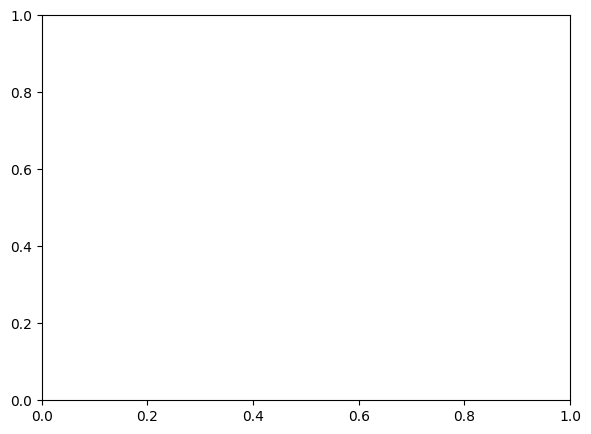

In [ ]:
import torch
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve, confusion_matrix
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, TrainerCallback
from datasets import Dataset

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Label mapping (handle imbalance)
label2id = {"pants-fire": 0, "false": 0, "barely-true": 0, "half-true": 1, "mostly-true": 1, "true": 1}
id2label = {v: k for k, v in label2id.items()}

# Custom callback to track best AUC-ROC
class AUCRocCallback(TrainerCallback):
    def __init__(self, tokenizer):
        super().__init__()
        self.best_auc_roc = 0.0
        self.best_model_path = ""
        self.auc_rocs = []
        self.tokenizer = tokenizer

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics and "eval_auc_roc" in metrics:
            current_auc = metrics["eval_auc_roc"]
            self.auc_rocs.append(current_auc)

            if current_auc > self.best_auc_roc:
                self.best_auc_roc = current_auc
                # Save the best model
                output_dir = f"./best_model_auc_{current_auc:.4f}"
                kwargs["model"].save_pretrained(output_dir)
                self.tokenizer.save_pretrained(output_dir)  # Use the stored tokenizer
                self.best_model_path = output_dir
                print(f"New best model with AUC-ROC {current_auc:.4f} saved to {output_dir}")

# Load model and tokenizer for BERT
MODEL_ID = "bert-base-uncased"
config = AutoConfig.from_pretrained(
    MODEL_ID,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, config=config).to(device)
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

# Load and preprocess data
def load_and_preprocess_data(train_path: str, test_path: str):
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    train_data.dropna(subset=["statement", "evidence", "label"], inplace=True)
    test_data.dropna(subset=["statement", "evidence", "label"], inplace=True)
    train_data["input_text"] = train_data["statement"] + " [SEP] " + train_data["evidence"]
    test_data["input_text"] = test_data["statement"] + " [SEP] " + test_data["evidence"]
    train_data["label"] = train_data["label"].map(label2id)
    test_data["label"] = test_data["label"].map(label2id)
    train_dataset = Dataset.from_pandas(train_data).shuffle(seed=SEED)
    test_dataset = Dataset.from_pandas(test_data).shuffle(seed=SEED)
    return train_dataset, test_dataset

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["input_text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

# Training arguments
training_args = TrainingArguments(
    output_dir="./model_output",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    weight_decay=0.05,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_auc_roc",
    greater_is_better=True,
    seed=SEED,
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=2,
)

# Compute evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()
    predictions = np.argmax(logits, axis=-1)

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro")
    accuracy = accuracy_score(labels, predictions)
    auc_roc = roc_auc_score(labels, probs) if len(np.unique(labels)) > 1 else 0.0

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc_roc": auc_roc,
    }

def plot_training_metrics(trainer_state, output_path="training_metrics.png"):
    # Extract metrics from trainer state
    metrics = trainer_state.log_history

    # Prepare data for plotting
    epochs = []
    train_loss = []
    eval_loss = []
    auc_rocs = []

    for entry in metrics:
        if "epoch" in entry:
            epochs.append(entry["epoch"])
            if "loss" in entry:
                train_loss.append(entry["loss"])
            if "eval_loss" in entry:
                eval_loss.append(entry["eval_loss"])
            if "eval_auc_roc" in entry:
                auc_rocs.append(entry["eval_auc_roc"])

    # Create figure with subplots
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Training Loss")
    plt.plot(epochs, eval_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # Plot AUC-ROC
    plt.subplot(1, 2, 2)
    plt.plot(epochs, auc_rocs, label="Validation AUC-ROC", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("AUC-ROC")
    plt.title("Validation AUC-ROC Across Epochs")
    plt.legend()

    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()
    print(f"Training metrics plot saved as {output_path}")

def plot_roc_curve(labels, probs, output_path="roc_curve.png"):
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig(output_path)
    plt.close()
    print(f"ROC curve saved as {output_path}")

def plot_confusion_matrix(labels, predictions, id2label, output_path="confusion_matrix.png"):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(id2label))
    plt.xticks(tick_marks, [id2label[i] for i in sorted(id2label.keys())], rotation=45)
    plt.yticks(tick_marks, [id2label[i] for i in sorted(id2label.keys())])

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()
    print(f"Confusion matrix saved as {output_path}")

def train_and_evaluate(train_path: str, test_path: str):
    train_dataset, test_dataset = load_and_preprocess_data(train_path, test_path)
    tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
    tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

    # Initialize callback with tokenizer
    auc_roc_callback = AUCRocCallback(tokenizer)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[auc_roc_callback]
    )

    start_time = time.time()
    trainer.train()
    end_time = time.time()
    print(f"Training completed in {end_time - start_time:.2f} seconds.")

    # Generate plots
    plot_training_metrics(trainer.state)

    # Final evaluation and plots
    predictions = trainer.predict(tokenized_test_dataset)
    pred_logits = predictions.predictions
    pred_probs = torch.nn.functional.softmax(torch.tensor(pred_logits), dim=-1)[:, 1].numpy()
    pred_labels = np.argmax(pred_logits, axis=-1)
    true_labels = predictions.label_ids

    plot_roc_curve(true_labels, pred_probs)
    plot_confusion_matrix(true_labels, pred_labels, id2label)

    # Print final metrics
    final_metrics = predictions.metrics
    print("\nFinal Evaluation Metrics:")
    print(f"AUC-ROC: {final_metrics.get('test_auc_roc', 0.0):.4f}")
    print(f"Accuracy: {final_metrics.get('test_accuracy', 0.0):.4f}")
    print(f"F1 Score: {final_metrics.get('test_f1', 0.0):.4f}")
    print(f"Precision: {final_metrics.get('test_precision', 0.0):.4f}")
    print(f"Recall: {final_metrics.get('test_recall', 0.0):.4f}")

    print(f"\nHighest AUC-ROC achieved: {auc_roc_callback.best_auc_roc:.4f}")
    print(f"Best model saved at: {auc_roc_callback.best_model_path}")

if __name__ == "__main__":
    train_path = "train_no_empty_evidence.csv"
    test_path = "test_no_empty_evidence.csv"
    train_and_evaluate(train_path, test_path)

In [ ]:
import json

# Load the training state file
with open("./model_output/checkpoint-944/trainer_state.json", "r") as f:
    trainer_state = json.load(f)

# Extract the log history
log_history = trainer_state["log_history"]


In [ ]:
import pandas as pd

# Convert log history to a DataFrame for easier plotting
log_df = pd.DataFrame(log_history)
log_df.head()


,epoch,eval_accuracy,eval_auc_roc,eval_f1,eval_loss,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,step,learning_rate,loss
0,1.00,0.583861,0.693311,0.423931,0.673543,0.642306,0.522447,15.1129,83.637,5.227,236,NaN,NaN
1,2.00,0.713608,0.789793,0.685480,0.584378,0.732377,0.685792,15.3076,82.573,5.161,472,NaN,NaN
2,2.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500,0.000017,0.6264
3,3.00,0.719937,0.790109,0.698092,0.646892,0.730295,0.696356,15.3958,82.100,5.131,708,NaN,NaN
4,4.00,0.731013,0.800515,0.711845,0.661678,0.740314,0.709153,15.2862,82.689,5.168,944,NaN,NaN


from matplotlib import pyplot as plt
_df_0['epoch'].plot(kind='hist', bins=20, title='epoch')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['eval_accuracy'].plot(kind='hist', bins=20, title='eval_accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['eval_auc_roc'].plot(kind='hist', bins=20, title='eval_auc_roc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['eval_f1'].plot(kind='hist', bins=20, title='eval_f1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='epoch', y='eval_accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='eval_accuracy', y='eval_auc_roc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='eval_auc_roc', y='eval_f1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='eval_f1', y='eval_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['eval_accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('eval_accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['eval_auc_roc']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('eval_auc_roc')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['eval_f1']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('eval_f1')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['eval_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('eval_loss')

from matplotlib import pyplot as plt
_df_12['epoch'].plot(kind='line', figsize=(8, 4), title='epoch')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['eval_accuracy'].plot(kind='line', figsize=(8, 4), title='eval_accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['eval_auc_roc'].plot(kind='line', figsize=(8, 4), title='eval_auc_roc')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['eval_f1'].plot(kind='line', figsize=(8, 4), title='eval_f1')
plt.gca().spines[['top', 'right']].set_visible(False)

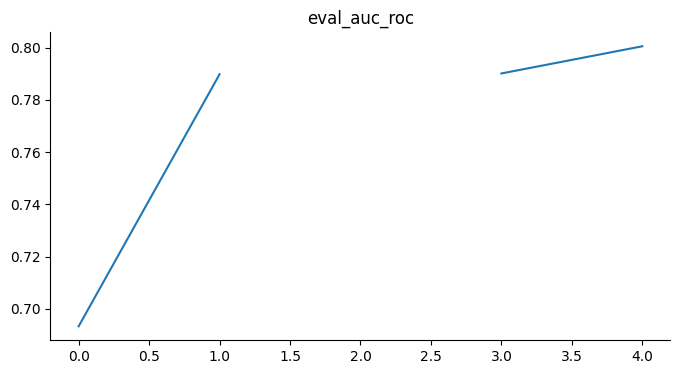

In [ ]:
from matplotlib import pyplot as plt
_df_14['eval_auc_roc'].plot(kind='line', figsize=(8, 4), title='eval_auc_roc')
plt.gca().spines[['top', 'right']].set_visible(False)

flan-t5

In [ ]:
# Save the model and tokenizer after training is complete
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")
print("Model and tokenizer saved to './saved_model' directory.")

In [ ]:
import time
import numpy as np
import pandas as pd
from scipy.special import softmax
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from datasets import Dataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
)

# -------------------------------
# Setup: Paths and Configurations
# -------------------------------
MODEL_ID = "google/flan-t5-small"

def load_and_prepare_data(train_data: pd.DataFrame, test_data: pd.DataFrame):
    """Prepare the datasets with label mappings."""
    # Combine 'statement' and 'evidence' columns as input
    for dataset in [train_data, test_data]:
        dataset["text"] = dataset["statement"] + " " + dataset["evidence"]

    # Define binary label mappings
    label2id = {
        "true": 1,
        "half-true": 1,
        "mostly-true": 1,
        "false": 0,
        "barely-true": 0,
        "pants-fire": 0,
    }
    id2label = {v: k for k, v in label2id.items()}

    train_data["label"] = train_data["label"].astype(str).map(label2id)
    test_data["label"] = test_data["label"].astype(str).map(label2id)

    # Drop missing values
    train_data.dropna(subset=["text", "label"], inplace=True)
    test_data.dropna(subset=["text", "label"], inplace=True)

    # Convert to HuggingFace Datasets
    train_dataset = Dataset.from_pandas(train_data).shuffle(seed=42)
    test_dataset = Dataset.from_pandas(test_data).shuffle(seed=42)

    return train_dataset, test_dataset, label2id, id2label

# -------------------------------
# Step 2: Load Model and Tokenizer
# -------------------------------
config = AutoConfig.from_pretrained(MODEL_ID, num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, config=config)
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

def tokenize_function(examples) -> dict:
    """Tokenize the text column in the dataset"""
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# -------------------------------
# Step 3: Define Training Arguments
# -------------------------------
training_args = TrainingArguments(
    num_train_epochs=5,
    output_dir="./model_output",  # Change output directory if needed
    logging_strategy="steps",
    logging_steps=100,
    report_to="tensorboard",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=False,  # Prevents overflow issues
    learning_rate=3e-4,
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=False,
)

# -------------------------------
# Step 4: Define Metrics Function (Updated to include ROC AUC)
# -------------------------------
def compute_metrics(eval_pred) -> dict:
    """Compute precision, recall, F1-score, accuracy, and ROC AUC for evaluation"""
    logits, labels = eval_pred
    if isinstance(logits, tuple):
        logits = logits[0]

    # Calculate probabilities using softmax
    probabilities = softmax(logits, axis=1)
    predictions = np.argmax(probabilities, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro")
    accuracy = accuracy_score(labels, predictions)

    # Calculate ROC AUC score
    try:
        roc_auc = roc_auc_score(labels, probabilities[:, 1])
    except ValueError:
        roc_auc = float("nan")

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
        "roc_auc": roc_auc,  # Added ROC AUC score
    }

# -------------------------------
# Step 5: Train and Evaluate the Model
# -------------------------------
def train_and_evaluate(train_data: pd.DataFrame, test_data: pd.DataFrame) -> None:
    """Train and evaluate the model."""
    train_dataset, test_dataset, label2id, id2label = load_and_prepare_data(train_data, test_data)
    tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
    tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_test_dataset,
        compute_metrics=compute_metrics,
    )

    start_time = time.time()
    trainer.train()
    end_time = time.time()
    print(f"Training completed in {end_time - start_time:.2f} seconds.")

    # Evaluate after training
    eval_results = trainer.evaluate()

    # Print out the evaluation results
    print("Evaluation Results:", eval_results)

    # Print each metric individually for clarity
    precision = eval_results.get("eval_precision", "N/A")
    recall = eval_results.get("eval_recall", "N/A")
    f1 = eval_results.get("eval_f1", "N/A")
    accuracy = eval_results.get("eval_accuracy", "N/A")
    roc_auc = eval_results.get("eval_roc_auc", "N/A")  # Added ROC AUC
    loss = eval_results.get("eval_loss", "N/A")

    print(f"Evaluation Loss: {loss}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")
    print(f"ROC AUC Score: {roc_auc}")  # Print ROC AUC score

    # Save model locally (without pushing to hub)
    model.save_pretrained("./model_output")  # Save model locally
    tokenizer.save_pretrained("./model_output")  # Save tokenizer locally

# -------------------------------
# Step 6: Run Training and Evaluation
# -------------------------------
if __name__ == "__main__":
    # Example: loading data from files (replace with actual file paths)
    train_data = pd.read_csv("train_no_empty_evidence.csv")
    test_data = pd.read_csv("test_no_empty_evidence.csv")

    train_and_evaluate(train_data, test_data)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google/flan-t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7557 [00:00<?, ? examples/s]

Map:   0%|          | 0/1264 [00:00<?, ? examples/s]

Step,Training Loss
100,0.683700
200,0.639600
300,0.616400
400,0.585100
500,0.563100
600,0.527100
700,0.508300
800,0.513100
900,0.511300
1000,0.459200


Training completed in 2711.96 seconds.


Evaluation Results: {'eval_loss': 1.2039713859558105, 'eval_precision': 0.7228998849252014, 'eval_recall': 0.6950833632926142, 'eval_f1': 0.6971162212887179, 'eval_accuracy': 0.7167721518987342, 'eval_roc_auc': 0.7903118059964458, 'eval_runtime': 34.1284, 'eval_samples_per_second': 37.037, 'eval_steps_per_second': 2.315, 'epoch': 5.0}
Evaluation Loss: 1.2039713859558105
Precision: 0.7228998849252014
Recall: 0.6950833632926142
F1 Score: 0.6971162212887179
Accuracy: 0.7167721518987342
ROC AUC Score: 0.7903118059964458
